In [1]:
import copy
import gc
import glob
import os
import time

import cv2
import IPython
import IPython.display
import joblib
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from joblib import Parallel, delayed
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm

%matplotlib inline

In [2]:
pd.options.display.max_columns = 128
pd.options.display.max_rows = 128
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
class EasyDict(dict):
    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(EasyDict, self).__setattr__(name, value)
        super(EasyDict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(EasyDict, self).pop(k, d)

## Configuration and global parameters:

In [4]:
train_df = pd.read_csv('../input/train_curated.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')
print('train: {}'.format(train_df.shape))
print('test: {}'.format(sample_submission.shape))

ROOT = '../input/'
test_root = os.path.join(ROOT, 'test/')
train_root = os.path.join(ROOT, 'train_curated/')


CONFIG = EasyDict()
CONFIG.hop_length = 347 # to make time steps 128
CONFIG.fmin = 20
CONFIG.fmax = 44100 / 2
CONFIG.n_fft = 480

N_SAMPLES = 48
SAMPLE_DIM = 256

TRAINING_CONFIG = {
    'sample_dim': (N_SAMPLES, SAMPLE_DIM),
    'padding_mode': cv2.BORDER_REFLECT,
}

print(CONFIG)
print(TRAINING_CONFIG)

train_df.head()

train: (4970, 2)
test: (1120, 81)
{'hop_length': 347, 'fmin': 20, 'fmax': 22050.0, 'n_fft': 480}
{'sample_dim': (48, 256), 'padding_mode': 2}


,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


## Data Processing class:

In [5]:
# Preprocessing functions inspired by:
# https://github.com/xiaozhouwang/tensorflow_speech_recognition_solution/blob/master/data.py
class DataProcessor(object):
    
    def __init__(self, debug=False):
        self.debug = debug
        
        # Placeholders for global statistics
        self.mel_mean = None
        self.mel_std = None
        self.mel_max = None
        self.mfcc_max = None
        
    def createMel(self, filename, params, normalize=False):
        """
        Create Mel Spectrogram sample out of raw wavfile
        """
        y, sr = librosa.load(filename, sr=None)
        mel = librosa.feature.melspectrogram(y, sr, n_mels=N_SAMPLES, **params)
        mel = librosa.power_to_db(mel)
        if normalize:
            if self.mel_mean is not None and self.mel_std is not None:
                mel = (mel - self.mel_mean) / self.mel_std
            else:
                sample_mean = np.mean(mel)
                sample_std = np.std(mel)
                mel = (mel - sample_mean) / sample_std
            if self.mel_max is not None:
                mel = mel / self.mel_max
            else:
                mel = mel / np.max(np.abs(mel))
        return mel
    
    def createMfcc(self, filename, params, normalize=False):
        """
        Create MFCC sample out of raw wavfile
        """
        y, sr = librosa.load(filename, sr=None)
        nonzero_idx = [y > 0]
        y[nonzero_idx] = np.log(y[nonzero_idx])
        mfcc = librosa.feature.mfcc(y, sr, n_mfcc=N_SAMPLES, **params)
        if normalize:
            if self.mfcc_max is not None:
                mfcc = mfcc / self.mfcc_max
            else:
                mfcc = mfcc / np.max(np.abs(mfcc))
        return mfcc
    
    def createLogspec(self, filename, params,
                      normalize=False,
                      window_size=20,
                      step_size=10, eps=1e-10):
        """
        Create log spectrogram,
        based on 
        https://www.kaggle.com/voglinio/keras-2d-model-5-fold-log-specgram-curated-only
        """
        
        y, sr = librosa.load(filename, sr=None)
        nperseg = int(round(window_size * sr / 1e3))
        noverlap = int(round(step_size * sr / 1e3))
        freqs, times, spec = scipy.signal.spectrogram(
            y,
            fs=sr,
            window='hann',
            nperseg=nperseg,
            noverlap=noverlap,
            detrend=False)
        spec = np.log(spec.astype(np.float32) + eps)
        return spec
        
    
    def prepareSample(self, root, row, 
                      preprocFunc, 
                      preprocParams, trainingParams, 
                      test_mode=False, normalize=False, 
                      proc_mode='split'):
        """
        Prepare sample for model training.
        Function takes row of DataFrame, extracts filename and labels and processes them.
        
        If proc_mode is 'split':
        Outputs sets of arrays of constant shape padded to TRAINING_CONFIG shape
        with selected padding mode, also specified in TRAINING_CONFIG.
        This approach prevents loss of information caused by trimming the audio sample,
        instead it splits it into equally-sized parts and pads them.
        To account for creation of multiple samples, number of labels are multiplied to a number
        equal to number of created samples.
        
        If proc_mode is 'resize':
        Resizes the original processed sample to (SAMPLE_DIM, N_SAMPLES) shape.
        """
        
        assert proc_mode in ['split', 'resize', 'raw'], 'proc_must be one of: split, resize, raw'
        
        filename = os.path.join(root, row['fname'])
        if not test_mode:
            labels = row['labels']
            
        sample = preprocFunc(filename, preprocParams, normalize=normalize)
        # print(sample.min(), sample.max())
        
        if proc_mode == 'split':
            sample_split = np.array_split(
                sample, np.ceil(sample.shape[1] / SAMPLE_DIM), axis=1)
            samples_pad = []
            for i in sample_split:
                padding_dim = SAMPLE_DIM - i.shape[1]
                sample_pad = cv2.copyMakeBorder(i, 0, 0, 0, padding_dim, trainingParams['padding_mode'])
                samples_pad.append(sample_pad)
            samples_pad = np.asarray(samples_pad)
            if not test_mode:
                labels = [labels] * len(samples_pad)
                labels = np.asarray(labels)
                return samples_pad, labels
            return samples_pad
        elif proc_mode == 'resize':
            sample_pad = cv2.resize(sample, (SAMPLE_DIM, N_SAMPLES), interpolation=cv2.INTER_NEAREST)
            sample_pad = np.expand_dims(sample_pad, axis=0)
            if not test_mode:
                labels = np.asarray(labels)
                return sample_pad, labels
            return sample_pad
        elif proc_mode == 'raw':
            if not test_mode:
                return sample, labels
            return sample


processor = DataProcessor()

In [6]:
DATA_PREFIX = 'logSpectrRaw'
train_filename = 'train_curated_{}.joblib'.format(DATA_PREFIX)
test_filename = 'test_{}.joblib'.format(DATA_PREFIX)


# Train processing/loading:
if os.path.isfile(train_filename):
    print('load processed train:')
    train_dict = joblib.load(train_filename)
    X_train = train_dict['X']
    y_train = train_dict['y']
    print(y_train.shape)
else:
    print('process train...')
    output = Parallel(n_jobs=-3, verbose=1)(
        delayed(processor.prepareSample)(
            train_root, 
            train_df.iloc[f, :],
            processor.createLogspec,
            CONFIG,
            TRAINING_CONFIG,
            test_mode=False,
            proc_mode='raw',
        ) for f in range(100))  # change to number of sample in train data for full processing
    X_train = [x[0] for x in output]
    X_train = list(map(lambda x: np.expand_dims(x, axis=-1), X_train))
    y_train = np.array([x[1] for x in output])
    y_train = pd.Series(y_train).str.get_dummies(sep=',')
    print(y_train.shape)
    # Save output for quicker experiments
    train_dict = {
        'X': X_train,
        'y': y_train,
    }
    joblib.dump(train_dict, train_filename)
    

# Test processing/loading:
if os.path.isfile(test_filename):
    print('load processed test:')
    test_dict = joblib.load(test_filename)
    X_test = test_dict['X']
    print(len(X_test))
else:
    print('process test...')
    X_test = Parallel(n_jobs=-3, verbose=1)(
        delayed(processor.prepareSample)(
            test_root, 
            sample_submission.iloc[f, :],
            processor.createLogspec,
            CONFIG,
            TRAINING_CONFIG,
            test_mode=True,
            proc_mode='raw',
        ) for f in range(100))  # change to number of sample in test data for full processing
    X_test = list(map(lambda x: np.expand_dims(x, axis=-1), X_test))
    test_dict = {
        'X': X_test,
    }
    joblib.dump(test_dict, test_filename)

process train...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    5.9s finished


(100, 55)
process test...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    3.2s finished


In [7]:
# Distribution of multilabel labels
print('Multilabel class distribution:')
print(y_train.sum(axis=1).value_counts())

# Most of the samples belong to only one class.
# There are some (around 15%), which belong to two classes.
# Occurrence of samples belonging to more than two classes at once
# is quite rare, around 1.5%t_

Multilabel class distribution:
1    91
2     9
dtype: int64


In [8]:
from collections import Counter
from pprint import pprint

df_lab = (y_train.loc[y_train.sum(axis=1) > 1] > 0)
multilabel_combs = []
for i in range(df_lab.shape[0]):
    row_label = df_lab.iloc[i, :][df_lab.iloc[i, :] > 0].index.tolist()
    multilabel_combs.append(row_label)

multilabel_comb_counter = Counter(list(map(lambda x: ' + '.join(x), multilabel_combs)))
pprint(multilabel_comb_counter.most_common(20))
# 20 most common combinations of labels

[('Sink_(filling_or_washing) + Water_tap_and_faucet', 2),
 ('Acoustic_guitar + Strum', 1),
 ('Cheering + Crowd', 1),
 ('Cheering + Clapping', 1),
 ('Crackle + Frying_(food)', 1),
 ('Church_bell + Traffic_noise_and_roadway_noise', 1),
 ('Fill_(with_liquid) + Sink_(filling_or_washing)', 1),
 ('Microwave_oven + Slam', 1)]


In [9]:
import numpy as np
import sklearn.metrics


# Based on https://www.kaggle.com/voglinio/keras-2d-model-5-fold-log-specgram-curated-only
# Core calculation of label precisions for one test sample.
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
        retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
        (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

# All-in-one calculation of per-class lwlrap.


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

# Calculate the overall lwlrap using sklearn.metrics function.


def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0,
        scores[nonzero_weight_sample_indices, :],
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


# Accumulator object version.

class lwlrap_accumulator(object):
    """Accumulate batches of test samples into per-class and overall lwlrap."""

    def __init__(self):
        self.num_classes = 0
        self.total_num_samples = 0

    def accumulate_samples(self, batch_truth, batch_scores):
        """Cumulate a new batch of samples into the metric.

        Args:
          truth: np.array of (num_samples, num_classes) giving boolean
            ground-truth of presence of that class in that sample for this batch.
          scores: np.array of (num_samples, num_classes) giving the
            classifier-under-test's real-valued score for each class for each
            sample.
        """
        assert batch_scores.shape == batch_truth.shape
        num_samples, num_classes = batch_truth.shape
        if not self.num_classes:
            self.num_classes = num_classes
            self._per_class_cumulative_precision = np.zeros(self.num_classes)
            self._per_class_cumulative_count = np.zeros(self.num_classes,
                                                        dtype=np.int)
        assert num_classes == self.num_classes
        for truth, scores in zip(batch_truth, batch_scores):
            pos_class_indices, precision_at_hits = (
                _one_sample_positive_class_precisions(scores, truth))
            self._per_class_cumulative_precision[pos_class_indices] += (
                precision_at_hits)
            self._per_class_cumulative_count[pos_class_indices] += 1
        self.total_num_samples += num_samples

    def per_class_lwlrap(self):
        """Return a vector of the per-class lwlraps for the accumulated samples."""
        return (self._per_class_cumulative_precision /
                np.maximum(1, self._per_class_cumulative_count))

    def per_class_weight(self):
        """Return a normalized weight vector for the contributions of each class."""
        return (self._per_class_cumulative_count /
                float(np.sum(self._per_class_cumulative_count)))

    def overall_lwlrap(self):
        """Return the scalar overall lwlrap for cumulated samples."""
        return np.sum(self.per_class_lwlrap() * self.per_class_weight())

In [10]:
# Class for defining transformations
class AudioAugment(object):
    
    def __init__(self, debug=False):
        self.debug = debug
    
    def doTransform(self, prob=0.5):
        if np.random.random() < prob:
            return True
        return False
        
    def horizontalFlip(self, x, prob=0.5):
        if self.doTransform(prob):
            x = np.flip(x, axis=1)
        return x
    
    def verticalFlip(self, x, prob=0.5):
        if self.doTransform(prob):
            x = np.flip(x, axis=0)
        return x
    
    def padSample(self, x, shape=(128, 128), prob=1, padding_mode=cv2.BORDER_CONSTANT):
        if self.doTransform(prob):
            padding_dim_x = shape[0] - x.shape[0]
            padding_dim_y = shape[1] - x.shape[1]
            if padding_dim_x > 0:
                x = cv2.copyMakeBorder(x, 0, 0, padding_dim_x, 0, padding_mode)
            if padding_dim_y > 0:
                x = cv2.copyMakeBorder(x, 0, 0, 0, padding_dim_y, padding_mode)
        return x
        
    def randomCrop(self, x, shape=(128, 128), prob=1):
        if self.doTransform(prob):
            xmin = np.random.randint(0, x.shape[0] - shape[0])
            ymin = np.random.randint(0, x.shape[1] - shape[1])
            xmax = xmin + shape[0]
            ymax = ymin + shape[1]
            x = x[xmin:xmax, ymin:ymax]
        return x
    
    def centerCrop(self, x, shape=(128, 128), prob=1):
        if self.doTransform(prob):
            xcent = x.shape[0] // 2
            ycent = x.shape[1] // 2
            xmin = xcent - shape[0] // 2
            ymin = ycent - shape[1] // 2
            xmax = xcent + shape[0] // 2
            ymax = ycent + shape[1] // 2
            x = x[xmin:xmax, ymin:ymax]
        return x
    
    def resizeSample(self, x, shape=(128, 128), prob=1, interpolation=cv2.INTER_NEAREST):
        if self.doTransform(prob):
            padding_dim_x = shape[0] - x.shape[0]
            padding_dim_y = shape[1] - x.shape[1]
            if padding_dim_x < 0 or padding_dim_y < 0 :
                x = cv2.resize(x, (shape[1], shape[0]), interpolation=interpolation)
        return x
    
    
# Class for applying augmentations
class AudioTransformer(AudioAugment):
    
    def __init__(self, transformations=False, transformations_params=False):
        self.transformations = transformations
        self.transformations_params = transformations_params
        
    def transform(self, x, args_set=None):
        for i in range(len(self.transformations)):
            kwargs = self.transformations_params[i]
            x = self.transformations[i](x, **kwargs)
        return x

orig sample shape: (442, 1413)
orig valid sample shape: (442, 809)
processed shapes:
(48, 256) (48, 256)


Text(0.5, 1.0, 'valid augmentation:')

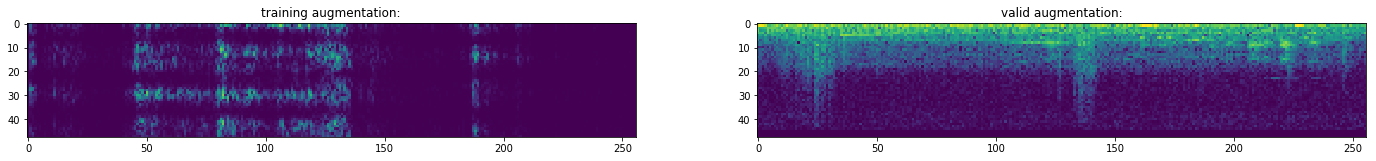

In [12]:
# Define augmentations for training & validation:
# Crop padding to be added before random/center crop 
TRAINING_CONFIG['sample_dim'] = (48, 256)
sample_crop_pad = 16


# Initialize augmentor
augmentor = AudioAugment()

# Example set of train transformations
train_transformer = AudioTransformer(
    transformations=[
        augmentor.padSample,
        augmentor.randomCrop,
    ],
    transformations_params=[
        {
            'shape': (TRAINING_CONFIG['sample_dim'][0] + sample_crop_pad,
                     TRAINING_CONFIG['sample_dim'][1] + sample_crop_pad),
            'padding_mode': cv2.BORDER_REFLECT,
        },
        {
            'shape': (TRAINING_CONFIG['sample_dim'][0],
                     TRAINING_CONFIG['sample_dim'][1]),
            'prob': 1.0,
        },
    ]
)

# Example set of validation transformations
valid_transformer = AudioTransformer(
    transformations=[
        augmentor.resizeSample,
        augmentor.centerCrop,
    ],
    transformations_params=[
        {
            'shape': (TRAINING_CONFIG['sample_dim'][0],
                      TRAINING_CONFIG['sample_dim'][1]),
        },
        {
            'shape': (TRAINING_CONFIG['sample_dim'][0],
                      TRAINING_CONFIG['sample_dim'][1]),
            'prob': 1.0,
        },
    ]
)


# Visualize augmented samples:
x = X_train[np.random.randint(0, len(X_train))][:, :, 0]
xv = X_train[np.random.randint(0, len(X_train))][:, :, 0]
print('orig sample shape: {}'.format(x.shape))
print('orig valid sample shape: {}'.format(xv.shape))
xc = train_transformer.transform(x)
xcv = valid_transformer.transform(xv)
print('processed shapes:')
print(xc.shape, xcv.shape)

fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].imshow(xc)
ax[0].set_title('training augmentation:')
ax[1].imshow(xcv)
ax[1].set_title('valid augmentation:')